In [5]:
import os
import time
from copy import copy
from pathlib import Path
from joblib import Memory
from scipy import sparse
from scipy.sparse import csc_matrix
from scipy.special import expit
from scipy.stats import pearsonr
import scikitplot as skplt
import shap

from sklearn import svm
from sklearn import tree
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample, shuffle
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, normalize
from sklearn import metrics
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

from xgboost import XGBClassifier
from category_encoders import TargetEncoder

import pyarrow.feather as feather
import matplotlib.pyplot as plt
import plotnine as p9
import pandas as pd
import numpy as np

rand_state = 5991

# Paths
my_filesys_pth = "C:/Code/GITHUB/csc/Classification-of-Pell-Institutions/"

idcsc = my_filesys_pth + "data/created_subsets/id_csc.feather"
tarcsc = my_filesys_pth + "data/created_subsets/tarcsc.feather"
fulldf = my_filesys_pth + "data/created_subsets/full_df.feather"

### Functions

In [6]:
def split_data(xx, yy, testsize = 1000):
    xtrain, xtest, y_train, y_test = train_test_split(xx,
                                                      yy,
                                                      test_size = testsize,
                                                      random_state = rand_state)
    xtrain, xvalid, y_train, y_valid = train_test_split(xtrain, y_train, 
                                                        test_size = testsize,
                                                        random_state = rand_state)
    y_train = np.array(y_train).reshape(-1, 1)
    y_test = np.array(y_test).reshape(-1, 1)
    y_valid = np.array(y_valid).reshape(-1, 1)

    print(" SHAPE of xtrain:", xtrain.shape)
    print("SHAPE of y_train:", y_train.shape)
    print("  SHAPE of xtest:", xtest.shape)
    print(" SHAPE of y_test:", y_test.shape)
    print(" SHAPE of xvalid:", xvalid.shape)
    print("SHAPE of y_valid:", y_valid.shape)

    return xtrain, y_train, xtest, y_test, xvalid, y_valid 

def get_acc_auc(y, p):
    acc = np.sum(y == p) / len(y)
    auc = roc_auc_score(y, p)
    return acc, auc

def get_outs(model, train, test, valid, ytrain, ytest, yvalid):
    train_acc = round(model.score(train, ytrain), 4)
    test_acc = round(model.score(test, ytest), 4)
    valid_acc = round(model.score(valid, yvalid), 4)

    train_auc = round(roc_auc_score(ytrain, model.predict_proba(train)[:,1]), 4)
    test_auc = round(roc_auc_score(ytest, model.predict_proba(test)[:,1]), 4)
    valid_auc = round(roc_auc_score(yvalid, model.predict_proba(valid)[:,1]), 4)

    return train_auc, test_auc, valid_auc, train_acc, test_acc, valid_acc  

### Data import and double check missing values

In [7]:
id_csc = feather.read_feather(idcsc)
tar_csc = feather.read_feather(tarcsc)
full_df = feather.read_feather(fulldf)

missing = pd.DataFrame(full_df.isna().sum())
missing.reset_index(inplace=True)
missing[missing[0] > 0]


,index,0


### Look at target values and grab KSU's data

In [8]:
df1 = id_csc.query("INSTNM == 'Kennesaw State University'")
df1["UNITID"] = "486840"

df2 = full_df.iloc[5587:5588]
df2["UNITID"] = "486840"

KSU_data = pd.merge(df1, df2, how = "left",
         left_on = "UNITID", right_on = "UNITID")

tar_csc

C:\Users\Nate\AppData\Local\Temp/ipykernel_1352/3139465179.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Nate\AppData\Local\Temp/ipykernel_1352/3139465179.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,ids,UNITID,PELLCAT
0,0,100654.0,0.0
1,1,100663.0,1.0
2,2,100690.0,0.0
3,3,100706.0,1.0
4,4,100724.0,0.0
...,...,...,...
5874,5874,493080.0,1.0
5875,5875,493150.0,0.0
5876,5876,493372.0,0.0
5877,5877,493424.0,0.0


### Split data into train, test, and validation datasets & drop problem variables

In [22]:
ys = tar_csc["PELLCAT"].copy()
full_df["ST_FIPS"] = full_df["ST_FIPS"].astype(int)
xs = full_df.drop(["ids", "UNITID", "FTFTPCTPELL", "ST_FIPS", "LOCALE_31"], axis = 1).copy()
print("SHAPE of xs:", xs.shape)
print("SHAPE of ys:", ys.shape)
xtrain, y_train, xtest, y_test, xvalid, y_valid = split_data(xs, ys, testsize = 1000)
print(xtrain.shape)

SHAPE of xs: (5879, 315)
SHAPE of ys: (5879,)
 SHAPE of xtrain: (3879, 315)
SHAPE of y_train: (3879, 1)
  SHAPE of xtest: (1000, 315)
 SHAPE of y_test: (1000, 1)
 SHAPE of xvalid: (1000, 315)
SHAPE of y_valid: (1000, 1)
(3879, 315)


In [23]:
xnot =  list(xtrain.columns[xtrain.columns.str.startswith("PELL")])
print("variables to be removed:")
print(len(xnot))
print("remaining variables:")

features = xtrain.columns
features2 = xtrain.columns.drop(xnot)

print(len(features2))

variables to be removed:
2
remaining variables:
313


### Feature Scaling
##### Creation of the standardized dataset & the standardized-transformed dataset

In [24]:
scaler = StandardScaler()
poly = PolynomialFeatures(3)

scaler.fit(xtrain[features])
xtrain2 = pd.DataFrame(scaler.transform(xtrain[features]), columns = features)
xvalid2 = pd.DataFrame(scaler.transform(xvalid[features]), columns = features)
xtest2 = pd.DataFrame(scaler.transform(xtest[features]), columns = features)

scaler.fit(xtrain[features2])
xtrain3 = pd.DataFrame(scaler.transform(xtrain[features2]), columns = features2)
xvalid3 = pd.DataFrame(scaler.transform(xvalid[features2]), columns = features2)
xtest3 = pd.DataFrame(scaler.transform(xtest[features2]), columns = features2)

print("      ORIGINAL -  xtrain before:", xtrain.shape)
print("        SCALED - xtrain2 before:", xtrain2.shape)
print("SCALED&REDUCED - xtrain3 before:", xtrain3.shape)

      ORIGINAL -  xtrain before: (3879, 315)
        SCALED - xtrain2 before: (3879, 315)
SCALED&REDUCED - xtrain3 before: (3879, 313)


### Checking for correlation between feature pairings

##### Original dataset

In [25]:
corrs = []
contFeat = list(xtrain.columns)
contFeat_length = len(contFeat)

for i in range(contFeat_length):
    for j in range(i + 1, contFeat_length):
        feati = xtrain[contFeat[i]].values.flatten()
        featj = xtrain[contFeat[j]].values.flatten()

        corr, _ = pearsonr(feati, featj)
        corrs.append([corr, abs(corr), contFeat[i], contFeat[j]])
correl = pd.DataFrame(corrs, columns = ["P_Corr", "P_Corr_abs", "feat1", "feat2"])
################################
# grb = correl.groupby(["feat1", "feat2"]).count()
# grb.sort_values("P_Corr_abs", ascending=False).to_csv("xtrain1_corrgroups.csv")
################################
tot_var_pair = (contFeat_length * (contFeat_length - 1) / 2)
num_var_g50 = len(correl[abs(correl["P_Corr"]) > 0.5])
pct_var_g50 = np.round(num_var_g50 / tot_var_pair * 100, 4)
print(xtrain.shape)
print(int(tot_var_pair), " : Total number of features pairs:")
print(num_var_g50, "   : Number of features pairs with absolute Pearson Correl above 0.5:")
print(pct_var_g50, "% : Percent of features pairs with absolute Pearson Correl above 0.5:")

C:\Users\Nate\anaconda3\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.


(3879, 315)
49455  : Total number of features pairs:
2008    : Number of features pairs with absolute Pearson Correl above 0.5:
4.0603 % : Percent of features pairs with absolute Pearson Correl above 0.5:


##### Standardized dataset

In [26]:
corrs = []
contFeat = list(xtrain2.columns)
contFeat_length = len(contFeat)

for i in range(contFeat_length):
    for j in range(i + 1, contFeat_length):
        feati = xtrain2[contFeat[i]].values.flatten()
        featj = xtrain2[contFeat[j]].values.flatten()

        corr, _ = pearsonr(feati, featj)
        corrs.append([corr, abs(corr), contFeat[i], contFeat[j]])
correl = pd.DataFrame(corrs, columns = ["P_Corr", "P_Corr_abs", "feat1", "feat2"])
################################
# grb = correl.groupby(["feat1", "feat2"]).count()
# grb.sort_values("P_Corr_abs", ascending=False).to_csv("xtrain1_corrgroups.csv")
################################
tot_var_pair = (contFeat_length * (contFeat_length - 1) / 2)
num_var_g50 = len(correl[abs(correl["P_Corr"]) > 0.5])
pct_var_g50 = np.round(num_var_g50 / tot_var_pair * 100, 4)
print(xtrain2.shape)
print(int(tot_var_pair), " : Total number of features pairs:")
print(num_var_g50, "   : Number of features pairs with absolute Pearson Correl above 0.5:")
print(pct_var_g50, "% : Percent of features pairs with absolute Pearson Correl above 0.5:")

(3879, 315)
49455  : Total number of features pairs:
2008    : Number of features pairs with absolute Pearson Correl above 0.5:
4.0603 % : Percent of features pairs with absolute Pearson Correl above 0.5:


##### Standardized and transformed dataset (before variable tranformation)

In [27]:
# SCALED AND REDUCED DATASET
corrs = []
contFeat = list(xtrain3.columns)
contFeat_length = len(contFeat)

for i in range(contFeat_length):
    for j in range(i + 1, contFeat_length):
        feati = xtrain3[contFeat[i]].values.flatten()
        featj = xtrain3[contFeat[j]].values.flatten()

        corr, _ = pearsonr(feati, featj)
        corrs.append([corr, abs(corr), contFeat[i], contFeat[j]])
correl = pd.DataFrame(corrs, columns = ["P_Corr", "P_Corr_abs", "feat1", "feat2"])
################################
# grb = correl.groupby(["feat1", "feat2"]).count()
# grb.sort_values("P_Corr_abs", ascending=False).to_csv("xtrain1_corrgroups.csv")
################################
tot_var_pair = (contFeat_length * (contFeat_length - 1) / 2)
num_var_g50 = len(correl[abs(correl["P_Corr"]) > 0.5])
pct_var_g50 = np.round(num_var_g50 / tot_var_pair * 100, 4)
print(xtrain3.shape)
print(int(tot_var_pair), " : Total number of features pairs:")
print(num_var_g50, "   : Number of features pairs with absolute Pearson Correl above 0.5:")
print(pct_var_g50, "% : Percent of features pairs with absolute Pearson Correl above 0.5:")

(3879, 313)
48828  : Total number of features pairs:
1934    : Number of features pairs with absolute Pearson Correl above 0.5:
3.9608 % : Percent of features pairs with absolute Pearson Correl above 0.5:


### Feature Transformation

In [28]:
# CREDIT: Dr. Vanderheyden wrote this code.
# During my study of Dr. Vanderheydens code below I created
# The get_acc_auc function and decided that the exponential
# and polynomial variables should not be created for this 
# project 
accuracies = []
for f in features2:
    log_reg = LogisticRegression(solver = "saga",
                                 random_state = rand_state,
                                 penalty = "l1",
                                 class_weight = "balanced",
                                 max_iter = 1000)
    x = xtrain3[f].values.reshape(-1, 1)
    y = y_train.reshape(-1, 1)
    ## LIN ##############################
    log_reg.fit(x, y)
    acc, auc = get_acc_auc(y, log_reg.predict(x))
    ## LOG #############################   
    xl = np.log(x - np.min(x) + 1)
    log_reg.fit(xl, y)
    lcc, luc = get_acc_auc(y, log_reg.predict(xl))

    if lcc / acc >= 1.1 or luc / auc >= 1.05:  # if bin accuracy is 110% of linear accuracy or ... AUC is 105% ...
        xtrain3[f + "_log"] = xl
        xvalid3[f + "_log"] = np.log(xvalid3[f].values.reshape(-1, 1) - np.min(xtrain3[f])+1)
        xtest3[f + "_log"] = np.log(xtest3[f].values.reshape(-1, 1) - np.min(xtrain3[f])+1)
    ## EXP #############################   
    xe = np.exp(x)
    log_reg.fit(xe, y)
    ecc, euc = get_acc_auc(y, log_reg.predict(xe))

    # if ecc / acc >= 1.1 or euc / auc >= 1.05: 
    #     xtrain3[f + "_exp"] = xe
    #     xvalid3[f + "_exp"] = np.exp(xvalid3[f].values.reshape(-1, 1))
    #     xtest3[f + "_exp"] = np.exp(xtest3[f].values.reshape(-1, 1))
    ## POLY ############################# 
    poly.fit(x)
    xp = poly.transform(x)
    log_reg.fit(xp, y)
    pcc, puc = get_acc_auc(y, log_reg.predict(xp))
    # if pcc / acc >= 1.1 or puc / auc >= 1.05:  # if bin accuracy is 110% of linear accuracy or ... AUC is 105% ...
    #     xtrain3[f + "_p2"] = x**2
    #     xtrain3[f + "_p3"] = x**3
    #     xvalid3[f + "_p2"] = (xvalid3[f].values)**2
    #     xvalid3[f + "_p3"] = (xvalid3[f].values)**3
    #     xtest3[f + "_p2"] = (xtest3[f].values)**2
    #     xtest3[f + "_p3"] = (xtest3[f].values)**3
    ## BIN #############################
    xmin = x.min()
    rnge = x.max() - xmin

    xtrn = 0 + ((x - xmin) > 1 * rnge / 10) + ((x - xmin) > 2 * rnge / 10) + ((x - xmin) > 3 * rnge / 10) + ( # the objects in each
                (x - xmin) > 4 * rnge / 10) + ((x - xmin) > 5 * rnge / 10) + ((x - xmin) > 6 * rnge / 10) + ( # bracket returns true
                (x - xmin) > 7 * rnge / 10) + ((x - xmin) > 8 * rnge / 10) + ((x - xmin) > 9 * rnge / 10)     # or false 
    xval = 0 + ((xvalid3[f] - xmin) > 1 * rnge / 10) + ((xvalid3[f] - xmin) > 2 * rnge / 10) + ((xvalid3[f] - xmin) > 3 * rnge / 10) + (
                (xvalid3[f] - xmin) > 4 * rnge / 10) + ((xvalid3[f] - xmin) > 5 * rnge / 10) + ((xvalid3[f] - xmin) > 6 * rnge / 10) + (
                (xvalid3[f] - xmin) > 7 * rnge / 10) + ((xvalid3[f] - xmin) > 8 * rnge / 10) + ((xvalid3[f] - xmin) > 9 * rnge / 10)
    xtst = 0 + ((xtest3[f] - xmin) > 1 * rnge / 10) + ((xtest3[f] - xmin) > 2 * rnge / 10) + ((xtest3[f] - xmin) > 5 * rnge / 10) + (
                (xtest3[f] - xmin) > 3 * rnge / 10) + ((xtest3[f] - xmin) > 4 * rnge / 10) + ((xtest3[f] - xmin) > 6 * rnge / 10) + (
                (xtest3[f] - xmin) > 7 * rnge / 10) + ((xtest3[f] - xmin) > 8 * rnge / 10) + ((xtest3[f] - xmin) > 9 * rnge / 10)
                
    encoder = TargetEncoder()

    encoder.fit(xtrn, y)
    xb = encoder.transform(xtrn)
    log_reg.fit(xb, y)

    bcc, buc = get_acc_auc(y, log_reg.predict(xb))

    if bcc / acc >= 1.1 or buc / auc >= 1.05: # if bin accuracy is 110% of linear accuracy or ... AUC is 105% ...
        xtrain3[f + "_Bin"] = xb
        xvalid3[f + "_Bin"] = encoder.transform(xval)
        xtest3[f + "_Bin"] = encoder.transform(xtst)
    ## COMPLETION #############################
    lDa = lcc / acc
    eDa = ecc / acc
    pDa = pcc / acc
    bDa = bcc / acc
    lda = luc / auc
    eda = euc / auc
    pda = puc / auc
    bda = buc / auc
    accuracies.append([f, acc, lcc, ecc, pcc, bcc, auc, luc, euc, puc, buc, lDa, eDa, pDa, bDa, lda, eda, pda, bda])
###############################################

colums = ["Feature","ACC: Linear", "ACC: Log", "ACC: Exp", "ACC: Poly3","ACC: Bin",
                    "AUC: Simple Linear", "AUC: Log", "AUC: Exp","AUC: Poly3", "AUC: Bin",
                    "ACC: LOG / Linear", "ACC: EXP / Linear", "ACC: Poly3 / Linear", "ACC: Bin / Linear",
                    "AUC: LOG / Linear", "AUC: EXP / Linear", "AUC: Poly3 / Linear", "AUC: Bin / Linear"]
accDf = pd.DataFrame(accuracies, columns = colums)

C:\Users\Nate\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\Nate\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\Nate\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\Nate\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\Nate\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataCo

In [29]:
print(xtrain3.shape)
# accDf.to_csv("acc_df.csv")
accDf.loc[:, ["Feature", "ACC: LOG / Linear", "ACC: EXP / Linear", "ACC: Poly3 / Linear", "ACC: Bin / Linear",
                         "AUC: LOG / Linear", "AUC: EXP / Linear", "AUC: Poly3 / Linear", "AUC: Bin / Linear"]
             ].sort_values("ACC: LOG / Linear", ascending = False).head(5)

(3879, 369)


,Feature,ACC: LOG / Linear,ACC: EXP / Linear,ACC: Poly3 / Linear,ACC: Bin / Linear,AUC: LOG / Linear,AUC: EXP / Linear,AUC: Poly3 / Linear,AUC: Bin / Linear
102,HIGHDEG_3,1.409317,1.048329,1.048329,1.000000,1.000000,1.000101,1.000101,1.000000
172,DBRR4_FED_UGCOMP_NUM,1.330419,1.330419,0.945212,0.948798,1.001850,1.001850,1.006084,0.999640
185,FIRSTGEN_DEBT_N,1.306961,1.409317,1.349170,1.388213,0.998297,1.000000,0.988764,1.023349
161,DBRR5_FED_UG_NUM,1.257023,1.334140,0.947856,0.951452,0.950008,0.979572,0.983712,0.967010
192,DBRR10_FED_UG_NUM,1.253416,1.329889,0.944836,0.948421,0.979251,0.992704,0.996900,0.979974


##### Standardized and transformed dataset (after variable tranformation)

In [30]:
corrs = []
contFeat = list(xtrain3.columns)
contFeat_length = len(contFeat)

for i in range(contFeat_length):
    for j in range(i + 1, contFeat_length):
        feati = xtrain3[contFeat[i]].values.flatten()
        featj = xtrain3[contFeat[j]].values.flatten()

        corr, _ = pearsonr(feati, featj)
        corrs.append([corr, abs(corr), contFeat[i], contFeat[j]])
correl = pd.DataFrame(corrs, columns = ["P_Corr", "P_Corr_abs", "feat1", "feat2"])
################################
# grb = correl.groupby(["feat1", "feat2"]).count()
# grb.sort_values("P_Corr_abs", ascending=False).to_csv("xtrain1_corrgroups.csv")
################################
tot_var_pair = (contFeat_length * (contFeat_length - 1) / 2)
num_var_g50 = len(correl[abs(correl["P_Corr"]) > 0.5])
pct_var_g50 = np.round(num_var_g50 / tot_var_pair * 100, 4)
print(xtrain3.shape)
print(int(tot_var_pair), " : Total number of features pairs:")
print(num_var_g50, "   : Number of features pairs with absolute Pearson Correl above 0.5:")
print(pct_var_g50, "% : Percent of features pairs with absolute Pearson Correl above 0.5:")

C:\Users\Nate\anaconda3\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.


(3879, 369)
67896  : Total number of features pairs:
3337    : Number of features pairs with absolute Pearson Correl above 0.5:
4.9149 % : Percent of features pairs with absolute Pearson Correl above 0.5:


### PCA

#### Original dataset

###### All variables

var    0.99962
dtype: float64
test average log-likelihood:  -inf
validation average log-likelihood:  -inf
train average log-likelihood:  -inf


,0,1
0,LPSTAFFORD_AMT,0.992446
1,LPPPLUS_AMT_y,0.004124
2,DBRR5_FED_UG_NUM,0.002702
3,DBRR1_FED_UG_NUM,0.000348
4,DBRR4_FED_UGUNK_NUM,0.000253


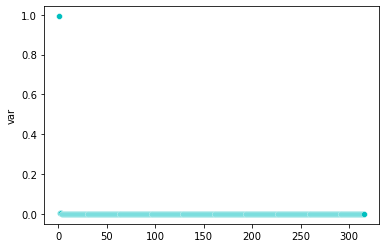

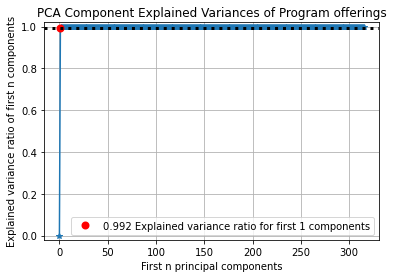

In [31]:
%matplotlib inline

xtrain_var = xtrain
xtest_var = xtest
xvalid_var = xvalid

initial_feature_names = list(xtrain_var.columns)

pca = PCA(#n_components = 5,
          random_state = rand_state) #  
principalComponents = pca.fit_transform(xtrain_var)

most_important = [np.abs(pca.components_[i]).argmax() for i in range(pca.components_.shape[0])]
most_important_names = [initial_feature_names[most_important[i]] for i in range(pca.components_.shape[0])]

pc_df = pd.DataFrame(data = principalComponents,
                     columns = most_important_names)
df = pd.DataFrame({'var': pca.explained_variance_ratio_})
pca_df = pd.DataFrame(pca.fit_transform(xtrain_var),
                      columns = most_important_names)

print(df[0:4].sum())
sns.scatterplot(x=range(1, pca_df.shape[1]+1),y="var", data=df, color="c");

print('test average log-likelihood: ', pca.score(xtest_var))
print('validation average log-likelihood: ', pca.score(xvalid_var))
print('train average log-likelihood: ', pca.score(xtrain_var))

skplt.decomposition.plot_pca_component_variance(pca,
                            title='PCA Component Explained Variances of Program offerings',
                            target_explained_variance=0.8,
                            ax=None,
                            figsize=None,
                            title_fontsize='large',
                            text_fontsize='medium')
plt.savefig(my_filesys_pth + 'images/ORIG/FULL/PCA/PCA_explainedvar.png')
interest_variable = pd.DataFrame([most_important_names,
                                  pca.explained_variance_ratio_]).T
interest_variable.sort_values([1], ascending = False).head(5) # LPPPLUS_AMT DBRR1_FED_UGCOMP_DEN

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [315] columns of the input dataframe.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[10]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


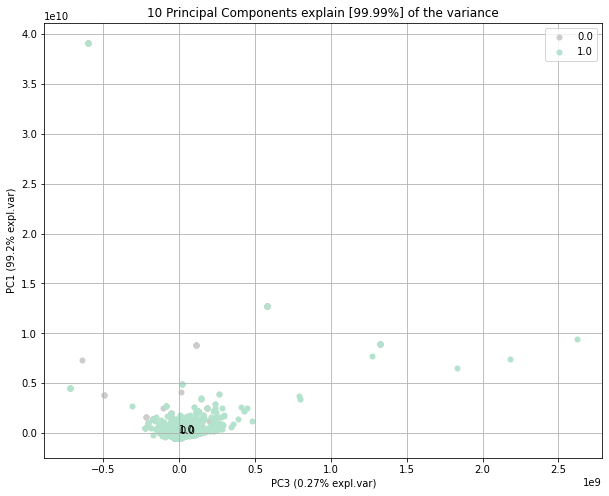

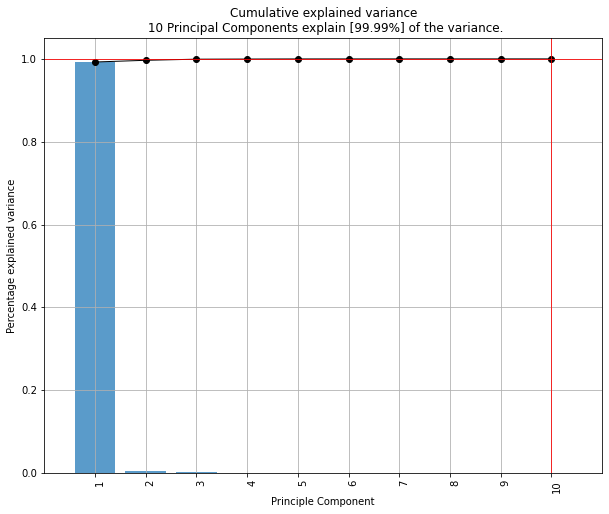

<Figure size 432x288 with 0 Axes>

In [32]:
from pca import pca

model = pca(n_components=10, random_state = rand_state)
results = model.fit_transform(xtrain_var)

model.scatter(y = y_train.reshape(-1,), legend=True, cmap='Pastel2_r', label = True, PC = [2, 0])
plt.savefig(my_filesys_pth + 'images/ORIG/FULL/PCA/PCA_scatter.png')

model.plot(n_components=10) 
plt.savefig(my_filesys_pth + 'images/ORIG/FULL/PCA/PCA_featureimportance.png')

###### Reduced to the 10 most independent

In [33]:
ddrp_lst = ['GRAD_DEBT_MDN10YR',"NOPELL_DEBT_N", 'DBRR4_FED_UGCOMP_RT','FTFTPCTFLOAN']

mutual_info = mutual_info_classif(xtrain.drop(ddrp_lst, axis = 1), y_train, random_state = rand_state)
sel_cols = SelectKBest(mutual_info_classif, k = 10)
sel_cols.fit(xtrain.drop(ddrp_lst, axis = 1), y_train)

lst = sel_cols.get_support()
lst = xtrain.drop(ddrp_lst, axis = 1).columns[lst]

x_train = xtrain[lst]
x_test = xtest[lst]
x_valid = xvalid[lst]

x_t1_lst = lst.copy()

%matplotlib inline

xtrain_var = x_train
xtest_var = x_test
xvalid_var = x_valid

initial_feature_names = list(xtrain_var.columns)

pca = PCA(#n_components = 5,
          random_state = rand_state) #  
principalComponents = pca.fit_transform(xtrain_var)

most_important = [np.abs(pca.components_[i]).argmax() for i in range(pca.components_.shape[0])]
most_important_names = [initial_feature_names[most_important[i]] for i in range(pca.components_.shape[0])]

pc_df = pd.DataFrame(data = principalComponents,
                     columns = most_important_names)
df = pd.DataFrame({'var': pca.explained_variance_ratio_})
pca_df = pd.DataFrame(pca.fit_transform(xtrain_var),
                      columns = most_important_names)

print(df[0:4].sum())
sns.scatterplot(x=range(1, pca_df.shape[1]+1),y="var", data=df, color="c");

print('test average log-likelihood: ', pca.score(xtest_var))
print('validation average log-likelihood: ', pca.score(xvalid_var))
print('train average log-likelihood: ', pca.score(xtrain_var))

skplt.decomposition.plot_pca_component_variance(pca,
                            title='PCA Component Explained Variances of Program offerings',
                            target_explained_variance=0.8,
                            ax=None,
                            figsize=None,
                            title_fontsize='large',
                            text_fontsize='medium')
plt.savefig(my_filesys_pth + 'images/ORIG/REDUC/PCA/PCA_explainedvar.png')

interest_variable = pd.DataFrame([most_important_names,
                                  pca.explained_variance_ratio_]).T
interest_variable.sort_values([1], ascending = False).head(10) # LPPPLUS_AMT DBRR1_FED_UGCOMP_DEN

KeyError: "['DBRR4_FED_UGCOMP_RT'] not found in axis"

In [ ]:
from pca import pca
model = pca(n_components=10, random_state = rand_state)
results = model.fit_transform(xtrain_var)
model.scatter(y = y_train.reshape(-1,), legend=True, cmap='Pastel2_r', label = True, PC = [0, 2])
plt.savefig(my_filesys_pth + 'images/ORIG/REDUC/PCA/PCA_scatter.png')

model.plot(n_components=10) 
plt.savefig(my_filesys_pth + 'images/ORIG/REDUC/PCA/PCA_featureimportance.png')

#### Standardized dataset

###### All variables

In [ ]:
file_specific_pth = "images/STAND/FULL/PCA/"

x_train2 = xtrain2
x_test2 = xtest2
x_valid2 = xvalid2

%matplotlib inline

xtrain_var = x_train2
xtest_var = x_test2
xvalid_var = x_valid2

initial_feature_names = list(xtrain_var.columns)

pca = PCA(#n_components = 80,
          random_state = rand_state) #  
principalComponents = pca.fit_transform(xtrain_var)

most_important = [np.abs(pca.components_[i]).argmax() for i in range(pca.components_.shape[0])]
most_important_names = [initial_feature_names[most_important[i]] for i in range(pca.components_.shape[0])]

pc_df = pd.DataFrame(data = principalComponents,
                     columns = most_important_names)
df = pd.DataFrame({'var': pca.explained_variance_ratio_})
pca_df = pd.DataFrame(pca.fit_transform(xtrain_var),
                      columns = most_important_names)

print(df[0:3].sum())
sns.scatterplot(x=range(1, pca_df.shape[1]+1),y="var", data=df, color="c");

print('test average log-likelihood: ', pca.score(xtest_var))
print('validation average log-likelihood: ', pca.score(xvalid_var))
print('train average log-likelihood: ', pca.score(xtrain_var))

skplt.decomposition.plot_pca_component_variance(pca,
                            title='PCA Component Explained Variances of Program offerings',
                            target_explained_variance=0.8,
                            ax=None,
                            figsize=None,
                            title_fontsize='large',
                            text_fontsize='medium')
plt.savefig(my_filesys_pth + file_specific_pth + 'PCA_explainedvar.png')
interest_variable = pd.DataFrame([most_important_names,
                                  pca.explained_variance_ratio_]).T
interest_variable.sort_values([1], ascending = False).head(10)

NameError: name 'xtrain2' is not defined

In [ ]:
from pca import pca

model = pca(n_components=80, random_state = rand_state)
results = model.fit_transform(xtrain_var)
# model.biplot(y = y_train.reshape(-1,), n_feat=3, legend=True, cmap='PiYG', label = False, d3=True, figsize=(14, 14))
model.scatter(y = y_train.reshape(-1,), legend=True, cmap='Pastel2_r', label = True, PC = [7, 3])#np.arange(0,k,1)) 7 2
plt.savefig(my_filesys_pth + file_specific_pth + 'PCA_scatter.png')

model.plot(n_components=4) 
plt.savefig(my_filesys_pth + file_specific_pth + 'PCA_featureimportance.png')

###### Reduced to the 10 most independent

In [ ]:
file_specific_pth = "images/STAND/REDUC/PCA/"

mutual_info = mutual_info_classif(xtrain2.drop("GRAD_DEBT_MDN", axis = 1), y_train, random_state = rand_state)
sel_five_cols = SelectKBest(mutual_info_classif, k = 10)
sel_five_cols.fit(xtrain2, y_train)
lst = sel_five_cols.get_support()
lst = xtrain2.columns[lst]
x_train2 = xtrain2[lst]
x_test2 = xtest2[lst]
x_valid2 = xvalid2[lst]

x_t2_lst = lst.copy()

%matplotlib inline

xtrain_var = x_train2
xtest_var = x_test2
xvalid_var = x_valid2

initial_feature_names = list(xtrain_var.columns)

pca = PCA(#n_components = 10,
          random_state = rand_state) #  
principalComponents = pca.fit_transform(xtrain_var)

most_important = [np.abs(pca.components_[i]).argmax() for i in range(pca.components_.shape[0])]
most_important_names = [initial_feature_names[most_important[i]] for i in range(pca.components_.shape[0])]

pc_df = pd.DataFrame(data = principalComponents,
                     columns = most_important_names)
df = pd.DataFrame({'var': pca.explained_variance_ratio_})
pca_df = pd.DataFrame(pca.fit_transform(xtrain_var),
                      columns = most_important_names)

print(df[0:3].sum())
sns.scatterplot(x=range(1, pca_df.shape[1]+1),y="var", data=df, color="c");

print('test average log-likelihood: ', pca.score(xtest_var))
print('validation average log-likelihood: ', pca.score(xvalid_var))
print('train average log-likelihood: ', pca.score(xtrain_var))

skplt.decomposition.plot_pca_component_variance(pca,
                            title='PCA Component Explained Variances of Program offerings',
                            target_explained_variance=0.8,
                            ax=None,
                            figsize=None,
                            title_fontsize='large',
                            text_fontsize='medium')
plt.savefig(my_filesys_pth + file_specific_pth + 'PCA_explainedvar.png')
interest_variable = pd.DataFrame([most_important_names,
                                  pca.explained_variance_ratio_]).T
interest_variable.sort_values([1], ascending = False).head(10)

NameError: name 'xtrain2' is not defined

In [ ]:
from pca import pca

model = pca(n_components=4, random_state = rand_state)
results = model.fit_transform(xtrain_var)
# model.biplot(y = y_train.reshape(-1,), n_feat=3, legend=True, cmap='PiYG', label = False, d3=True, figsize=(14, 14))
model.scatter(y = y_train.reshape(-1,), legend=True, cmap='Pastel2_r', label = True, PC = [0, 1])#np.arange(0,k,1)) 7 2
plt.savefig(my_filesys_pth + file_specific_pth + 'PCA_scatter.png')

model.plot(n_components=4) 
plt.savefig(my_filesys_pth + file_specific_pth + 'PCA_featureimportance.png')

#### Standardized-Transformed dataset

###### All variables

In [ ]:
file_specific_pth = "images/STAND_TRAN/FULL/PCA/"
# drrp = ["CCBASIC_31_exp", "CCUGPROF_8_exp", "OMENRYP_FULLTIME_exp", "OMACHT8_FTFT_exp", "OPEFLAG_3_exp", "CCBASIC_25_exp", "CCUGPROF_0_exp", "INEXPFTE_exp"]
%matplotlib inline

xtrain_var = xtrain3
xtest_var = xtest3
xvalid_var = xvalid3

initial_feature_names = list(xtrain_var.columns)

pca = PCA(#n_components = 80,
          random_state = rand_state) #  
principalComponents = pca.fit_transform(xtrain_var)

most_important = [np.abs(pca.components_[i]).argmax() for i in range(pca.components_.shape[0])]
most_important_names = [initial_feature_names[most_important[i]] for i in range(pca.components_.shape[0])]

pc_df = pd.DataFrame(data = principalComponents,
                     columns = most_important_names)
df = pd.DataFrame({'var': pca.explained_variance_ratio_})
pca_df = pd.DataFrame(pca.fit_transform(xtrain_var),
                      columns = most_important_names)

print(df[0:3].sum())
sns.scatterplot(x=range(1, pca_df.shape[1]+1),y="var", data=df, color="c");

print('test average log-likelihood: ', pca.score(xtest_var))
print('validation average log-likelihood: ', pca.score(xvalid_var))
print('train average log-likelihood: ', pca.score(xtrain_var))

skplt.decomposition.plot_pca_component_variance(pca,
                            title='PCA Component Explained Variances of Program offerings',
                            target_explained_variance=0.8,
                            ax=None,
                            figsize=None,
                            title_fontsize='large',
                            text_fontsize='medium')
plt.savefig(my_filesys_pth + file_specific_pth + 'PCA_explainedvar.png')
interest_variable = pd.DataFrame([most_important_names,
                                  pca.explained_variance_ratio_]).T
interest_variable.sort_values([1], ascending = False).head(10)

NameError: name 'xtrain3' is not defined

In [ ]:
from pca import pca

model = pca(n_components=80, random_state = rand_state)
results = model.fit_transform(xtrain_var)
model.scatter(y = y_train.reshape(-1,), legend=True, cmap='Pastel2_r', label = True, PC = [0, 3])
plt.savefig(my_filesys_pth + file_specific_pth + 'PCA_scatter.png')

model.plot(n_components=10) 
plt.savefig(my_filesys_pth + file_specific_pth + 'PCA_featureimportance.png')

###### Reduced to the 10 most independent

In [ ]:
file_specific_pth = "images/STAND_TRAN/REDUC/PCA/"
ddrp_lst = ['GRAD_DEBT_MDN'] #,'TUITIONFEE_IN_exp', 'TUITIONFEE_IN_p3', 'TUITIONFEE_OUT_p3', 'MALE_DEBT_MDN_p3', 'TUITIONFEE_OUT_p2',"NOPELL_DEBT_N_exp", "AVGFACSAL_exp"]
mutual_info = mutual_info_classif(xtrain3.drop(ddrp_lst, axis = 1), y_train, random_state=rand_state)
sel_five_cols = SelectKBest(mutual_info_classif, k = 10)
sel_five_cols.fit(xtrain3.drop(ddrp_lst, axis = 1), y_train)
lst = sel_five_cols.get_support()
lst = xtrain3.drop(ddrp_lst, axis = 1).columns[lst]
x_train3 = xtrain3[lst]
x_test3 = xtest3[lst]
x_valid3 = xvalid3[lst]

x_t3_lst = lst

%matplotlib inline
k = 50

xtrain_var = x_train3
xtest_var = x_test3
xvalid_var = x_valid3
print(xtrain_var.shape)

initial_feature_names = list(xtrain_var.columns)

pca = PCA(n_components = 10,
          random_state = rand_state) #  
principalComponents = pca.fit_transform(xtrain_var)

most_important = [np.abs(pca.components_[i]).argmax() for i in range(pca.components_.shape[0])]
most_important_names = [initial_feature_names[most_important[i]] for i in range(pca.components_.shape[0])]

pc_df = pd.DataFrame(data = principalComponents,
                     columns = most_important_names)
df = pd.DataFrame({'var': pca.explained_variance_ratio_})
pca_df = pd.DataFrame(pca.fit_transform(xtrain_var),
                      columns = most_important_names)

print(df[0:2].sum())
sns.scatterplot(x=range(1, pca_df.shape[1]+1),y="var", data=df, color="c");

print('test average log-likelihood: ', pca.score(xtest_var))
print('validation average log-likelihood: ', pca.score(xvalid_var))
print('train average log-likelihood: ', pca.score(xtrain_var))

skplt.decomposition.plot_pca_component_variance(pca,
                            title='PCA Component Explained Variances of Program offerings',
                            target_explained_variance=0.8,
                            ax=None,
                            figsize=None,
                            title_fontsize='large',
                            text_fontsize='medium')
plt.savefig(my_filesys_pth + file_specific_pth + 'PCA_explainedvar.png')
interest_variable = pd.DataFrame([most_important_names,
                                  pca.explained_variance_ratio_]).T
interest_variable = interest_variable.sort_values([1], ascending = False)
interest_variable

NameError: name 'xtrain3' is not defined

In [ ]:
from pca import pca
model = pca(n_components=5, random_state = rand_state)
results = model.fit_transform(xtrain_var)
model.scatter(y = y_train.reshape(-1,), legend=True, cmap='Pastel2_r', label = True, PC = [1, 4])#np.arange(0,k,1)) 1 4    2  1     3 0
plt.savefig(my_filesys_pth + file_specific_pth + 'PCA_scatter.png')

model.plot(n_components=5) 
plt.savefig(my_filesys_pth + file_specific_pth + 'PCA_featureimportance.png')

### Logistic Regression

#### Original dataset

###### All variables

In [ ]:
file_specific_pth = "images/ORIG/FULL/LogReg/"

xtrain_var = xtrain
xtest_var = xtest
xvalid_var = xvalid

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

logReg = LogisticRegression(solver = "saga",
                            random_state = rand_state, 
                            penalty = "l1", 
                            C = 0.01, 
                            class_weight = "balanced",
                            max_iter = 10)
logReg.fit(xtrain_var, y_train_var)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, xtrain_var, xtest_var, xvalid_var, y_train_var, y_test_var, y_valid_var)

if train_auc > best_train_auc:
    best_train_auc = train_auc
if test_auc > best_test_auc:
    best_test_auc = test_auc
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy



print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

cm = confusion_matrix(y_test, logReg.predict(xtest_var))
print("Ratio of T / F", (cm[0,0] + cm[1,1]) / (cm[0,1] + cm[1,0]))

print("Ratio of T / F", (cm[0,0] + cm[1,1]) / (cm[0,1] + cm[1,0]))

cm = confusion_matrix(y_valid, logReg.predict(xvalid_var))
metrics.plot_roc_curve(logReg, xtest_var, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'LG_ROC_test.png')

cm = confusion_matrix(y_test, logReg.predict(xtest_var))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'LG_ConfuMatrix_test.png')

metrics.plot_roc_curve(logReg, xvalid_var, y_valid)
plt.savefig(my_filesys_pth + file_specific_pth + 'LG_ROC_valid.png')

cm = confusion_matrix(y_valid, logReg.predict(xvalid_var))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'LG_ConfuMatrix_valid.png')

NameError: name 'xtrain' is not defined

###### Reduced to the 10 most independent

In [ ]:
file_specific_pth = "images/ORIG/REDUC/LogReg/"

xtrain_var = x_train[x_t1_lst]
xtest_var = x_test[x_t1_lst]
xvalid_var = x_valid[x_t1_lst]

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

logReg = LogisticRegression(solver = "saga",
                            random_state = rand_state, 
                            penalty = "l2", 
                            C = 0.1, 
                            class_weight = "balanced",
                            max_iter = 50)
logReg.fit(xtrain_var, y_train_var)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, xtrain_var, xtest_var, xvalid_var, y_train_var, y_test_var, y_valid_var)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
if test_auc > best_test_auc:
    best_test_auc = test_auc
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

cm = confusion_matrix(y_valid, logReg.predict(xvalid_var))
metrics.plot_roc_curve(logReg, xtest_var, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'LG_ROC_test.png')

cm = confusion_matrix(y_test, logReg.predict(xtest_var))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'LG_ConfuMatrix_test.png')

metrics.plot_roc_curve(logReg, xvalid_var, y_valid)
plt.savefig(my_filesys_pth + file_specific_pth + 'LG_ROC_valid.png')

cm = confusion_matrix(y_valid, logReg.predict(xvalid_var))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'LG_ConfuMatrix_valid.png')

NameError: name 'x_train' is not defined

#### Standardized dataset

###### All variables

In [ ]:
file_specific_pth = "images/STAND/FULL/LogReg/"

xtrain_var = xtrain2
xtest_var = xtest2
xvalid_var = xvalid2

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

logReg = LogisticRegression(solver = "saga",
                            random_state = rand_state, 
                            penalty = "l1", 
                            C = 0.05, 
                            class_weight = "balanced",
                            max_iter = 500)
logReg.fit(xtrain_var, y_train_var)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, xtrain_var, xtest_var, xvalid_var, y_train_var, y_test_var, y_valid_var)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
if test_auc > best_test_auc:
    best_test_auc = test_auc
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(logReg, xtest_var, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'LG_ROC.png')

cm = confusion_matrix(y_test, logReg.predict(xtest_var))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'LG_ConfuMatrix.png')

NameError: name 'xtrain2' is not defined

###### Reduced to the 10 most independent

In [ ]:
file_specific_pth = "images/STAND/REDUC/LogReg/"

xtrain_var = xtrain2[x_t2_lst]
xtest_var = xtest2[x_t2_lst]
xvalid_var = xvalid2[x_t2_lst]

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

logReg = LogisticRegression(solver = "saga",
                            random_state = rand_state, 
                            penalty = "l1", 
                            C = 0.01, 
                            class_weight = "balanced",
                            max_iter = 50)
logReg.fit(xtrain_var, y_train_var)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, xtrain_var, xtest_var, xvalid_var, y_train_var, y_test_var, y_valid_var)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
if test_auc > best_test_auc:
    best_test_auc = test_auc
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(logReg, xtest_var, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'LG_ROC.png')

cm = confusion_matrix(y_test, logReg.predict(xtest_var))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'LG_ConfuMatrix.png')

NameError: name 'xtrain2' is not defined

#### Standardized-Transformed dataset

###### All variables

In [ ]:
file_specific_pth = "images/STAND_TRAN/FULL/LogReg/"

xtrain_var = xtrain3
xtest_var = xtest3
xvalid_var = xvalid3

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

logReg = LogisticRegression(solver = "saga",
                            random_state = rand_state, 
                            penalty = "l1", 
                            C = 0.1, 
                            class_weight = "balanced",
                            max_iter = 100)
logReg.fit(xtrain_var, y_train_var)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, xtrain_var, xtest_var, xvalid_var, y_train_var, y_test_var, y_valid_var)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
if test_auc > best_test_auc:
    best_test_auc = test_auc
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(logReg, xtest_var, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'LG_ROC.png')

cm = confusion_matrix(y_test, logReg.predict(xtest_var))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'LG_ConfuMatrix.png')

###### Reduced to the 10 most independent

In [ ]:
file_specific_pth = "images/STAND_TRAN/REDUC/LogReg/"

xtrain_var = x_train3[x_t3_lst]
xtest_var = x_test3[x_t3_lst]
xvalid_var = x_valid3[x_t3_lst]

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

logReg = LogisticRegression(solver = "saga",
                            random_state = rand_state, 
                            penalty = "l2", 
                            C = 0.005, 
                            class_weight = "balanced",
                            max_iter = 1)
logReg.fit(xtrain_var, y_train_var)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, xtrain_var, xtest_var, xvalid_var, y_train_var, y_test_var, y_valid_var)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
if test_auc > best_test_auc:
    best_test_auc = test_auc
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(logReg, xtest_var, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'LG_ROC.png')

cm = confusion_matrix(y_test, logReg.predict(xtest_var))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'LG_ConfuMatrix.png')

### Logistic Regression with PCA

#### Original dataset

###### All variables

In [ ]:
file_specific_pth = "images/ORIG/FULL/LogRegPCA/"

xtrain_var = xtrain
xtest_var = xtest
xvalid_var = xvalid

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

pca = PCA(n_components = 3)
pca.fit(xtrain_var)

train_img = pca.transform(xtrain_var)
test_img = pca.transform(xtest_var)
valid_img = pca.transform(xvalid_var)

logReg = LogisticRegression(solver = "saga",
                            random_state = rand_state, 
                            penalty = "l2", 
                            C = 0.01, 
                            class_weight = "balanced",
                            max_iter = 10)
logReg.fit(train_img, y_train_var)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, train_img, test_img, valid_img, y_train_var, y_test_var, y_valid_var)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
    b_tr_auc = outs
if test_auc > best_test_auc:
    best_test_auc = test_auc
    b_ts_auc = outs
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc
    b_v_auc = outs

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
    b_tr_acc = outs
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
    b_ts_acc = outs
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy
    b_v_acc = outs

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(logReg, test_img, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'LGPCA_ROC.png')

cm = confusion_matrix(y_test, logReg.predict(test_img))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'LGPCA_ConfuMatrix.png')

###### Reduced to the 10 most independent

In [ ]:
file_specific_pth = "images/ORIG/REDUC/LogRegPCA/"

xtrain_var = x_train[x_t1_lst]
xtest_var = x_test[x_t1_lst]
xvalid_var = x_valid[x_t1_lst]

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

pca = PCA(n_components = 8)
pca.fit(xtrain_var)

train_img = pca.transform(xtrain_var)
test_img = pca.transform(xtest_var)
valid_img = pca.transform(xvalid_var)

logReg = LogisticRegression(solver = "saga",
                            random_state = rand_state, 
                            penalty = "l1", 
                            C = .001, 
                            class_weight = "balanced",
                            max_iter = 100)
logReg.fit(train_img, y_train_var)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, train_img, test_img, valid_img, y_train_var, y_test_var, y_valid_var)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
    b_tr_auc = outs
if test_auc > best_test_auc:
    best_test_auc = test_auc
    b_ts_auc = outs
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc
    b_v_auc = outs

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
    b_tr_acc = outs
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
    b_ts_acc = outs
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy
    b_v_acc = outs

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(logReg, test_img, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'LGPCA_ROC.png')

cm = confusion_matrix(y_test, logReg.predict(test_img))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'LGPCA_ConfuMatrix.png')

#### Standardized dataset

###### All variables

In [ ]:
file_specific_pth = "images/STAND/FULL/LogRegPCA/"

xtrain_var = xtrain2
xtest_var = xtest2
xvalid_var = xvalid2

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

pca = PCA()
pca.fit(xtrain_var)

train_img = pca.transform(xtrain_var)
test_img = pca.transform(xtest_var)
valid_img = pca.transform(xvalid_var)

logReg = LogisticRegression(solver = "saga",
                            random_state = rand_state, 
                            penalty = "l1", 
                            C = 1, 
                            class_weight = "balanced",
                            max_iter = 200)
logReg.fit(train_img, y_train_var)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, train_img, test_img, valid_img, y_train_var, y_test_var, y_valid_var)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
    b_tr_auc = outs
if test_auc > best_test_auc:
    best_test_auc = test_auc
    b_ts_auc = outs
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc
    b_v_auc = outs

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
    b_tr_acc = outs
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
    b_ts_acc = outs
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy
    b_v_acc = outs

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(logReg, test_img, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'LGPCA_ROC.png')

cm = confusion_matrix(y_test, logReg.predict(test_img))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'LGPCA_ConfuMatrix.png')

###### Reduced to the 10 most independent

In [ ]:
file_specific_pth = "images/STAND/REDUC/LogRegPCA/"

xtrain_var = xtrain2[x_t2_lst]
xtest_var = xtest2[x_t2_lst]
xvalid_var = xvalid2[x_t2_lst]

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

pca = PCA()
pca.fit(xtrain_var)

train_img = pca.transform(xtrain_var)
test_img = pca.transform(xtest_var)
valid_img = pca.transform(xvalid_var)

logReg = LogisticRegression(solver = "saga",
                            random_state = rand_state, 
                            penalty = "l1", 
                            C = 0.01, 
                            class_weight = "balanced",
                            max_iter = 200)
logReg.fit(train_img, y_train_var)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, train_img, test_img, valid_img, y_train_var, y_test_var, y_valid_var)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
    b_tr_auc = outs
if test_auc > best_test_auc:
    best_test_auc = test_auc
    b_ts_auc = outs
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc
    b_v_auc = outs

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
    b_tr_acc = outs
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
    b_ts_acc = outs
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy
    b_v_acc = outs

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(logReg, test_img, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'LGPCA_ROC.png')

cm = confusion_matrix(y_test, logReg.predict(test_img))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'LGPCA_ConfuMatrix.png')

#### Standardized-Transformed dataset

###### All variables

In [ ]:
file_specific_pth = "images/STAND_TRAN/FULL/LogRegPCA/"

xtrain_var = xtrain3
xtest_var = xtest3
xvalid_var = xvalid3

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

pca = PCA()
pca.fit(xtrain_var)

train_img = pca.transform(xtrain_var)
test_img = pca.transform(xtest_var)
valid_img = pca.transform(xvalid_var)

logReg = LogisticRegression(solver = "saga",
                            random_state = rand_state, 
                            penalty = "l2", 
                            C = 0.01, 
                            class_weight = "balanced",
                            max_iter = 200)
logReg.fit(train_img, y_train_var)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, train_img, test_img, valid_img, y_train_var, y_test_var, y_valid_var)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
    b_tr_auc = outs
if test_auc > best_test_auc:
    best_test_auc = test_auc
    b_ts_auc = outs
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc
    b_v_auc = outs

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
    b_tr_acc = outs
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
    b_ts_acc = outs
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy
    b_v_acc = outs

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(logReg, test_img, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'LGPCA_ROC.png')

cm = confusion_matrix(y_test, logReg.predict(test_img))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'LGPCA_ConfuMatrix.png')

###### Reduced to the 10 most independent

In [ ]:
file_specific_pth = "images/STAND_TRAN/REDUC/LogRegPCA/"

xtrain_var = x_train3[x_t3_lst]
xtest_var = x_test3[x_t3_lst]
xvalid_var = x_valid3[x_t3_lst]

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

pca = PCA()
pca.fit(xtrain_var)

train_img = pca.transform(xtrain_var)
test_img = pca.transform(xtest_var)
valid_img = pca.transform(xvalid_var)

logReg = LogisticRegression(solver = "saga",
                            random_state = rand_state, 
                            penalty = "l2", 
                            C = 0.01, 
                            class_weight = "balanced",
                            max_iter = 200)
logReg.fit(train_img, y_train_var)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, train_img, test_img, valid_img, y_train_var, y_test_var, y_valid_var)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
    b_tr_auc = outs
if test_auc > best_test_auc:
    best_test_auc = test_auc
    b_ts_auc = outs
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc
    b_v_auc = outs

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
    b_tr_acc = outs
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
    b_ts_acc = outs
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy
    b_v_acc = outs

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(logReg, test_img, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'LGPCA_ROC.png')

cm = confusion_matrix(y_test, logReg.predict(test_img))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'LGPCA_ConfuMatrix.png')

### KNN with PCA

#### Standardized dataset

###### All variables

In [ ]:
file_specific_pth = "images/STAND/FULL/KNN/"

x_train_var = xtrain2
x_test_var = xtest2
x_valid_var = xvalid2
train_y = pd.DataFrame(y_train)

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

pca = PCA(random_state = rand_state)
pca.fit(x_train_var)

train_img = pd.DataFrame(pca.transform(x_train_var))
test_img = pd.DataFrame(pca.transform(x_test_var))
valid_img = pd.DataFrame(pca.transform(x_valid_var))
knc = KNeighborsClassifier(leaf_size=5,
                           metric = "euclidean",
                           n_neighbors = 55,
                           weights = "distance",
                           algorithm = 'auto')
	
knc.fit(train_img, train_y)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(knc, train_img, test_img, valid_img, y_train, y_test, y_valid)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
    b_tr_auc = outs
if test_auc > best_test_auc:
    best_test_auc = test_auc
    b_ts_auc = outs
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc
    b_v_auc = outs

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
    b_tr_acc = outs
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
    b_ts_acc = outs
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy
    b_v_acc = outs

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(knc, test_img, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'KNN_ROC.png')

cm = confusion_matrix(y_test, knc.predict(test_img))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = knc.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'KNN_ConfuMatrix.png')

###### Reduced to the 10 most independent

In [ ]:
file_specific_pth = "images/STAND/REDUC/KNN/"

x_train_var = x_train2[x_t2_lst]
x_test_var = x_test2[x_t2_lst]
x_valid_var = x_valid2[x_t2_lst]

pca = PCA(random_state = rand_state)
pca.fit(xtrain_var)

train_img = pd.DataFrame(pca.transform(xtrain_var))
test_img = pd.DataFrame(pca.transform(xtest_var))
valid_img = pd.DataFrame(pca.transform(xvalid_var))
knc = KNeighborsClassifier(leaf_size=35,
                           metric = "euclidean",
                           n_neighbors = 60,
                           weights = "distance",
                           algorithm = 'auto')
	
knc.fit(train_img, train_y)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(knc, train_img, test_img, valid_img, y_train, y_test, y_valid)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
    b_tr_auc = outs
if test_auc > best_test_auc:
    best_test_auc = test_auc
    b_ts_auc = outs
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc
    b_v_auc = outs

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
    b_tr_acc = outs
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
    b_ts_acc = outs
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy
    b_v_acc = outs

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(knc, test_img, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'KNN_ROC.png')

cm = confusion_matrix(y_test, knc.predict(test_img))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = knc.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'KNN_ConfuMatrix.png')

#### Standardized-Transformed dataset

###### All variables

In [ ]:
file_specific_pth = "images/STAND_TRAN/FULL/KNN/"

x_train_var = xtrain3
x_test_var = xtest3
x_valid_var = xvalid3

train_y = pd.DataFrame(y_train.reshape(-1,))

pca = PCA(random_state = rand_state)
pca.fit(xtrain_var)

train_img = pd.DataFrame(pca.transform(xtrain_var))
test_img = pd.DataFrame(pca.transform(xtest_var))
valid_img = pd.DataFrame(pca.transform(xvalid_var))

knc = KNeighborsClassifier(leaf_size=35,
                           metric = "euclidean",
                           n_neighbors = 55,
                           weights = "uniform",
                           algorithm = 'auto')

knc.fit(train_img, train_y)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(knc, train_img, test_img, valid_img, y_train, y_test, y_valid)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
    b_tr_auc = outs
if test_auc > best_test_auc:
    best_test_auc = test_auc
    b_ts_auc = outs
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc
    b_v_auc = outs

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
    b_tr_acc = outs
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
    b_ts_acc = outs
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy
    b_v_acc = outs

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(knc, test_img, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'KNN_ROC.png')

cm = confusion_matrix(y_test, knc.predict(test_img))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = knc.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'KNN_ConfuMatrix.png')

knc_explainer = shap.KernelExplainer(knc.predict, shap.sample(test_img, 10))
knc_shap_values = knc_explainer.shap_values(test_img)
shap.summary_plot(knc_shap_values, test_img)

###### Reduced to the 10 most independent

In [ ]:
file_specific_pth = "images/STAND_TRAN/REDUC/KNN/"

x_train_var = x_train3[x_t3_lst]
x_test_var = x_test3[x_t3_lst]
x_valid_var = x_valid3[x_t3_lst]

pca = PCA(random_state = rand_state)
pca.fit(xtrain_var)

train_img = pd.DataFrame(pca.transform(xtrain_var))
test_img = pd.DataFrame(pca.transform(xtest_var))
valid_img = pd.DataFrame(pca.transform(xvalid_var))
knc = KNeighborsClassifier(leaf_size=35,
                           metric = "euclidean",
                           n_neighbors = 55,
                           weights = "uniform",
                           algorithm = 'auto')

knc.fit(train_img, train_y)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(knc, train_img, test_img, valid_img, y_train, y_test, y_valid)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
    b_tr_auc = outs
if test_auc > best_test_auc:
    best_test_auc = test_auc
    b_ts_auc = outs
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc
    b_v_auc = outs

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
    b_tr_acc = outs
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
    b_ts_acc = outs
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy
    b_v_acc = outs

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(knc, test_img, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'KNN_ROC.png')

cm = confusion_matrix(y_test, knc.predict(test_img))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = knc.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'KNN_ConfuMatrix.png')

### XGBoost

#### Original dataset

###### All variables

In [ ]:
file_specific_pth = "images/ORIG/FULL/XGB/"

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

train_x = pd.DataFrame(xtrain)
test_x = pd.DataFrame(xtest)
valid_x = pd.DataFrame(xvalid)

train_y = pd.DataFrame(y_train)
test_y = pd.DataFrame(y_test)
valid_y = pd.DataFrame(y_valid)

x1 = train_x[(train_y == 1).values]
y1 = train_y[(train_y == 1).values]

x, y = resample(x1, y1,
                replace = True,
                n_samples = (len(train_y) - 2*sum(train_y)),
                random_state = rand_state)

xt = pd.concat([train_x, x])
yt = pd.concat([train_y, y])

xs, ys = shuffle(xt, yt, 
                 random_state = rand_state)

xgb = XGBClassifier(learning_rate = 0.10, 
                    max_depth = 2,
                    gamma = 0.5,
                    n_estimators = 400)

eval_set = [(train_x, train_y), (valid_x, valid_y)]

xgb.fit(xs, ys, 
        eval_metric='auc', 
        eval_set = eval_set)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(xgb, train_x, test_x, valid_x, train_y, test_y, valid_y)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
        best_train_auc = train_auc
if test_auc > best_test_auc:
        best_test_auc = test_auc
if valid_auc > best_valid_auc:
        best_valid_auc = valid_auc
if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(xgb, test_x, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'XGB_ROC.png')

cm = confusion_matrix(y_test, xgb.predict(test_x))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = xgb.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'XGB_ConfuMatrix.png')

###### Reduced to the 10 most independent

In [ ]:
file_specific_pth = "images/ORIG/FULL/XGB/"

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

train_x = pd.DataFrame(xtrain[x_t1_lst])
test_x = pd.DataFrame(xtest[x_t1_lst])
valid_x = pd.DataFrame(xvalid[x_t1_lst])

train_y = pd.DataFrame(y_train)
test_y = pd.DataFrame(y_test)
valid_y = pd.DataFrame(y_valid)

x1 = train_x[(train_y == 1).values]
y1 = train_y[(train_y == 1).values]

x, y = resample(x1, y1,
                replace = True,
                n_samples = (len(train_y) - 2*sum(train_y)),
                random_state = rand_state)

xt = pd.concat([train_x, x])
yt = pd.concat([train_y, y])

xs, ys = shuffle(xt, yt, 
                 random_state = rand_state)

xgb = XGBClassifier(learning_rate = 0.10, 
                max_depth = 2,
                gamma = 0.5,
                n_estimators = 400)

eval_set = [(train_x, train_y), (valid_x, valid_y)]

xgb.fit(xs, ys, 
        eval_metric='auc', 
        eval_set = eval_set)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(xgb, train_x, test_x, valid_x, train_y, test_y, valid_y)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
        best_train_auc = train_auc
if test_auc > best_test_auc:
        best_test_auc = test_auc
if valid_auc > best_valid_auc:
        best_valid_auc = valid_auc
if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(xgb, test_x, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'XGB_ROC.png')

cm = confusion_matrix(y_test, xgb.predict(test_x))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = xgb.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'XGB_ConfuMatrix.png')

#### Standardized dataset

###### All variables

In [ ]:
file_specific_pth = "images/ORIG/REDUC/XGB/"

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

train_x = pd.DataFrame(xtrain2)
test_x = pd.DataFrame(xtest2)
valid_x = pd.DataFrame(xvalid2)

train_y = pd.DataFrame(y_train)
test_y = pd.DataFrame(y_test)
valid_y = pd.DataFrame(y_valid)

x1 = train_x[(train_y == 1).values]
y1 = train_y[(train_y == 1).values]

x, y = resample(x1, y1,
                replace = True,
                n_samples = (len(train_y) - 2*sum(train_y)),
                random_state = rand_state)

xt = pd.concat([train_x, x])
yt = pd.concat([train_y, y])

xs, ys = shuffle(xt, yt, 
                 random_state = rand_state)

xgb = XGBClassifier(learning_rate = 0.10, 
                max_depth = 2,
                gamma = 0.5,
                n_estimators = 400)

eval_set = [(train_x, train_y), (valid_x, valid_y)]

xgb.fit(xs, ys, 
        eval_metric='auc', 
        eval_set = eval_set)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(xgb, train_x, test_x, valid_x, train_y, test_y, valid_y)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
        best_train_auc = train_auc
if test_auc > best_test_auc:
        best_test_auc = test_auc
if valid_auc > best_valid_auc:
        best_valid_auc = valid_auc
if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(xgb, test_x, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'XGB_ROC.png')

cm = confusion_matrix(y_test, xgb.predict(test_x))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = xgb.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'XGB_ConfuMatrix.png')

###### Reduced to the 10 most independent

In [ ]:
file_specific_pth = "images/STAND/REDUC/XGB/"

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

train_x = pd.DataFrame(x_train2[x_t2_lst])
test_x = pd.DataFrame(x_test2[x_t2_lst])
valid_x = pd.DataFrame(x_valid2[x_t2_lst])

train_y = pd.DataFrame(y_train)
test_y = pd.DataFrame(y_test)
valid_y = pd.DataFrame(y_valid)

x1 = train_x[(train_y == 1).values]
y1 = train_y[(train_y == 1).values]

x, y = resample(x1, y1,
                replace = True,
                n_samples = (len(train_y) - 2*sum(train_y)),
                random_state = rand_state)

xt = pd.concat([train_x, x])
yt = pd.concat([train_y, y])

xs, ys = shuffle(xt, yt, 
                 random_state = rand_state)

xgb = XGBClassifier(learning_rate = 0.10, 
                max_depth = 6,
                gamma = 0.5,
                n_estimators = 400)

eval_set = [(train_x, train_y), (valid_x, valid_y)]

xgb.fit(xs, ys, 
        eval_metric='auc', 
        eval_set = eval_set)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(xgb, train_x, test_x, valid_x, train_y, test_y, valid_y)

if train_auc > best_train_auc:
        best_train_auc = train_auc
if test_auc > best_test_auc:
        best_test_auc = test_auc
if valid_auc > best_valid_auc:
        best_valid_auc = valid_auc
if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(xgb, test_x, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'XGB_ROC.png')

cm = confusion_matrix(y_test, xgb.predict(test_x))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = xgb.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'XGB_ConfuMatrix.png')

#### Standardized-Transformed dataset

###### All variables

In [ ]:
file_specific_pth = "images/STAND_TRAN/FULL/XGB/"

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

train_x = pd.DataFrame(xtrain3)
test_x = pd.DataFrame(xtest3)
valid_x = pd.DataFrame(xvalid3)

train_y = pd.DataFrame(y_train)
test_y = pd.DataFrame(y_test)
valid_y = pd.DataFrame(y_valid)

x1 = train_x[(train_y == 1).values]
y1 = train_y[(train_y == 1).values]

x, y = resample(x1, y1,
                replace = True,
                n_samples = (len(train_y) - 2*sum(train_y)),
                random_state = rand_state)

xt = pd.concat([train_x, x])
yt = pd.concat([train_y, y])

xs, ys = shuffle(xt, yt, 
                 random_state = rand_state)

xgb = XGBClassifier(learning_rate = 0.10, 
                max_depth = 2,
                gamma = 0.5,
                n_estimators = 400)

eval_set = [(train_x, train_y), (valid_x, valid_y)]

xgb.fit(xs, ys, 
        eval_metric='auc', 
        eval_set = eval_set)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(xgb, train_x, test_x, valid_x, train_y, test_y, valid_y)

if train_auc > best_train_auc:
        best_train_auc = train_auc
if test_auc > best_test_auc:
        best_test_auc = test_auc
if valid_auc > best_valid_auc:
        best_valid_auc = valid_auc
if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(xgb, test_x, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'XGB_ROC.png')

cm = confusion_matrix(y_test, xgb.predict(test_x))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = xgb.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'XGB_ConfuMatrix.png')

###### Reduced to the 10 most independent

In [ ]:
file_specific_pth = "images/STAND_TRAN/REDUC/XGB/"

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

train_x = pd.DataFrame(x_train3[x_t3_lst])
test_x = pd.DataFrame(x_test3[x_t3_lst])
valid_x = pd.DataFrame(x_valid3[x_t3_lst])

train_y = pd.DataFrame(y_train)
test_y = pd.DataFrame(y_test)
valid_y = pd.DataFrame(y_valid)

x1 = train_x[(train_y == 1).values]
y1 = train_y[(train_y == 1).values]

x, y = resample(x1, y1,
                replace = True,
                n_samples = (len(train_y) - 2*sum(train_y)),
                random_state = rand_state)

xt = pd.concat([train_x, x])
yt = pd.concat([train_y, y])

xs, ys = shuffle(xt, yt, 
                 random_state = rand_state)

xgb = XGBClassifier(learning_rate = 0.70, 
                min_split_loss = 0,
                max_depth = 4,
                gamma = 0.01,
                min_child_weight = 1,
                max_delta_step = 0,
                subsample = 1,
                n_estimators = 1000)

eval_set = [(train_x, train_y), (valid_x, valid_y)]

xgb.fit(xs, ys, 
        eval_metric='auc', 
        eval_set = eval_set)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(xgb, train_x, test_x, valid_x, train_y, test_y, valid_y)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
        best_train_auc = train_auc
if test_auc > best_test_auc:
        best_test_auc = test_auc
if valid_auc > best_valid_auc:
        best_valid_auc = valid_auc
if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(xgb, test_x, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'XGB_ROC.png')

cm = confusion_matrix(y_test, xgb.predict(test_x))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = xgb.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'XGB_ConfuMatrix.png')

### Random Forest

#### Original dataset

###### All variables

In [ ]:
file_specific_pth = "images/ORIG/FULL/RanFor/"

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

xtrain_var = xtrain
xtest_var = xtest
xvalid_var = xvalid

Random_forest = RandomForestClassifier(n_estimators = 700, #  The number of trees in the forest.
                                       criterion = "entropy",
                                       max_depth = 6,  
                                       min_samples_leaf = 6,
                                       class_weight = 'balanced_subsample',
                                       random_state = rand_state)
Random_forest.fit(xtrain_var, y_train)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(Random_forest, xtrain_var, xtest_var, xvalid_var, y_train, y_test, y_valid)

if train_auc > best_train_auc:
        best_train_auc = train_auc
if test_auc > best_test_auc:
        best_test_auc = test_auc
if valid_auc > best_valid_auc:
        best_valid_auc = valid_auc
if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(Random_forest, xtest_var, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'RF_ROC.png')

cm = confusion_matrix(y_test, Random_forest.predict(xtest_var))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = Random_forest.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'RF_ConfuMatrix.png')

###### Reduced to the 10 most independent

In [ ]:
file_specific_pth = "images/ORIG/REDUC/RanFor/"

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

xtrain_var = xtrain[x_t1_lst]
xtest_var = xtest[x_t1_lst]
xvalid_var = xvalid[x_t1_lst]

Random_forest = RandomForestClassifier(n_estimators = 700, #  The number of trees in the forest.
                                       criterion = "entropy",
                                       max_depth = 6,  
                                       min_samples_leaf = 6,
                                       class_weight = 'balanced_subsample',
                                       random_state = rand_state)
Random_forest.fit(xtrain_var, y_train)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(Random_forest, xtrain_var, xtest_var, xvalid_var, y_train, y_test, y_valid)

if train_auc > best_train_auc:
        best_train_auc = train_auc
if test_auc > best_test_auc:
        best_test_auc = test_auc
if valid_auc > best_valid_auc:
        best_valid_auc = valid_auc
if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(Random_forest, xtest_var, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'RF_ROC.png')

cm = confusion_matrix(y_test, Random_forest.predict(xtest_var))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = Random_forest.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'RF_ConfuMatrix.png')

#### Standardized dataset

###### All variables

In [ ]:
file_specific_pth = "images/STAND/FULL/RanFor/"

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

xtrain_var = xtrain2
xtest_var = xtest2
xvalid_var = xvalid2

Random_forest = RandomForestClassifier(n_estimators = 700, #  The number of trees in the forest.
                                       criterion = "entropy",
                                       max_depth = 6,  
                                       min_samples_leaf = 6,
                                       class_weight = 'balanced_subsample',
                                       random_state = rand_state)
Random_forest.fit(xtrain_var, y_train)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(Random_forest, xtrain_var, xtest_var, xvalid_var, y_train, y_test, y_valid)

if train_auc > best_train_auc:
        best_train_auc = train_auc
if test_auc > best_test_auc:
        best_test_auc = test_auc
if valid_auc > best_valid_auc:
        best_valid_auc = valid_auc
if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(Random_forest, xtest_var, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'RF_ROC.png')

cm = confusion_matrix(y_test, Random_forest.predict(xtest_var))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = Random_forest.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'RF_ConfuMatrix.png')

###### Reduced to the 10 most independent

In [ ]:
file_specific_pth = "images/STAND/REDUC/RanFor/"

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

xtrain_var = xtrain2[x_t2_lst]
xtest_var = xtest2[x_t2_lst]
xvalid_var = xvalid2[x_t2_lst]

Random_forest = RandomForestClassifier(n_estimators = 700, #  The number of trees in the forest.
                                       criterion = "entropy",
                                       max_depth = 6,  
                                       min_samples_leaf = 6,
                                       class_weight = 'balanced_subsample',
                                       random_state = rand_state)
Random_forest.fit(xtrain_var, y_train)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(Random_forest, xtrain_var, xtest_var, xvalid_var, y_train, y_test, y_valid)

if train_auc > best_train_auc:
        best_train_auc = train_auc
if test_auc > best_test_auc:
        best_test_auc = test_auc
if valid_auc > best_valid_auc:
        best_valid_auc = valid_auc
if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(Random_forest, xtest_var, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'RF_ROC.png')

cm = confusion_matrix(y_test, Random_forest.predict(xtest_var))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = Random_forest.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'RF_ConfuMatrix.png')

sorted_idx = Random_forest.feature_importances_.argsort()
plt.barh(xtrain_var.columns.values[sorted_idx], Random_forest.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.savefig(my_filesys_pth + file_specific_pth + 'RF_featimport.png')

class_name = ["Majority Pell institution", "Minority Pell institution"]

explainer = shap.TreeExplainer(Random_forest)
shap_values = explainer.shap_values(xtest_var)
shap.summary_plot(shap_values[0], xtest_var, class_names = class_name, feature_names = xtest_var.columns.values)
plt.savefig(my_filesys_pth + file_specific_pth + 'RF_beeswarm.png')

#### Standardized-Transformed dataset

###### All variables

In [ ]:
file_specific_pth = "images/STAND_TRAN/FULL/RanFor/"

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

xtrain_var = xtrain3
xtest_var = xtest3
xvalid_var = xvalid3

Random_forest = RandomForestClassifier(n_estimators = 700, #  The number of trees in the forest.
                                       criterion = "entropy",
                                       max_depth = 6,  
                                       min_samples_leaf = 6,
                                       class_weight = 'balanced_subsample',
                                       random_state = rand_state)
Random_forest.fit(xtrain_var, y_train)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(Random_forest, xtrain_var, xtest_var, xvalid_var, y_train, y_test, y_valid)

if train_auc > best_train_auc:
        best_train_auc = train_auc
if test_auc > best_test_auc:
        best_test_auc = test_auc
if valid_auc > best_valid_auc:
        best_valid_auc = valid_auc
if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(Random_forest, xtest_var, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'RF_ROC.png')

cm = confusion_matrix(y_test, Random_forest.predict(xtest_var))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = Random_forest.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'RF_ConfuMatrix.png')

###### Reduced to the 10 most independent

In [ ]:
file_specific_pth = "images/STAND_TRAN/REDUC/RanFor/"

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

xtrain_var = xtrain3[x_t3_lst]
xtest_var = xtest3[x_t3_lst]
xvalid_var = xvalid3[x_t3_lst]

Random_forest = RandomForestClassifier(n_estimators = 700, #  The number of trees in the forest.
                                       criterion = "entropy",
                                       max_depth = 6,  
                                       min_samples_leaf = 6,
                                       class_weight = 'balanced_subsample',
                                       random_state = rand_state)
Random_forest.fit(xtrain_var, y_train)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(Random_forest, xtrain_var, xtest_var, xvalid_var, y_train, y_test, y_valid)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
        best_train_auc = train_auc
if test_auc > best_test_auc:
        best_test_auc = test_auc
if valid_auc > best_valid_auc:
        best_valid_auc = valid_auc
if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(Random_forest, xtest_var, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'RF_ROC.png')

cm = confusion_matrix(y_test, Random_forest.predict(xtest_var))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = Random_forest.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'RF_ConfuMatrix.png')